In [1]:
import xarray as xr 
import cartopy
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import cv2

In [2]:
# 读取nc数据
initData = xr.open_dataset(r"C:\Users\2892706668\Desktop\GRIDSAT-B1.2023.07.23.03.v02r01.nc")
initData_t2 = xr.open_dataset(r"C:\Users\2892706668\Desktop\GRIDSAT-B1.2023.07.23.06.v02r01.nc")
initData_t3 = xr.open_dataset(r"C:\Users\2892706668\Desktop\GRIDSAT-B1.2023.07.23.09.v02r01.nc")


In [3]:
print(initData.irwin_cdr.shape)

(1, 2000, 5143)


In [4]:
def draw_img(lon, lat , data):
    fig, ax  = plt.subplots(
                            figsize = (10,8), 
                            subplot_kw = {'projection': ccrs.PlateCarree()}
                          )
    grid = ax.gridlines(draw_labels=True)
    grid.top_labels = False
    grid.right_labels = False
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.COASTLINE)
    # 限定范围
    ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())
    
    img = ax.contourf(lon, lat, data, 
                                cmap = "coolwarm", 
                                transform = ccrs.PlateCarree())
    # 防止中文乱码
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False


# 椭圆拟合

# 连续区域识别

## 找出需要的亮温区

In [5]:
tb = initData.irwin_cdr[0].to_numpy()
tb2 = initData_t2.irwin_cdr[0].to_numpy()
tb3 = initData_t3.irwin_cdr[0].to_numpy()
print(tb)
# 取出tb的非nan的值
print(tb[~np.isnan(tb)].max())
print(tb[~np.isnan(tb)].min())

[[      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [265.86    265.86    266.31    ...       nan 265.86    265.86   ]
 ...
 [281.79    281.79    281.79    ... 281.72    281.72    281.79   ]
 [281.72    281.72    281.79    ... 281.82    281.72    281.72   ]
 [281.82    281.82    281.82    ... 282.08002 282.08002 282.08002]]
319.22
188.02


In [6]:
# 找边界
# 阈值处理：找出所有Tb < 225K的像素
_, cold_cores = cv2.threshold(tb, 225, 255, cv2.THRESH_BINARY_INV)
cold_cores = cold_cores.astype(np.uint8)   # # 转换为8位无符号整型以便后续处理

# 同样地，找出所有Tb < 241K的像素
_, cold_regions = cv2.threshold(tb, 241, 255, cv2.THRESH_BINARY_INV)
cold_regions = cold_regions.astype(np.uint8)

# 使用形态学膨胀操作扩展冷云核心
kernel = np.ones((1,1), np.uint8)  # 定义一个1x1的结构元素
ccs_map = cv2.dilate(cold_cores, kernel, iterations= 1)

# 只保留那些在Tb < 241K范围内的扩展区域
ccs_map = cv2.bitwise_and(ccs_map, cold_regions)

# 拿出真实的值  
# print("\n所有符合条件的 Tb 值：\n", tb[ccs_map == 255])

# 连通区域部分
# 假设cold_cores和cold_regions已经通过阈值分割得到
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cold_regions.astype(np.uint8), connectivity=8)


In [141]:
print(num_labels)
print(stats.shape)
print(centroids.shape)

print(ccs_map.shape)
print(initData.lat.shape)

6113
(6113, 5)
(6113, 2)
(2000, 5143)
(2000,)


In [8]:
# 计算每个像素对应的真实面积（km²）
R = 6371  # 地球半径（km）
dlon = 0.07
dlat = 0.07

# 转换为弧度 , 弧度单位rad
dlon_rad = np.radians(dlon)
dlat_rad = np.radians(dlat)

# 创建一个与 cold_regions 形状相同的面积矩阵（每个像素的面积）
area_per_pixel_km2 = np.zeros_like(cold_regions, dtype=np.float32)

for i in range(cold_regions.shape[0]):  # 遍历每一行（纬度）
    lat_rad = np.radians(initData.lat[i])  # 当前行的纬度（假设已知）
    area = (R ** 2) * dlon_rad * dlat_rad * np.cos(lat_rad)
    area_per_pixel_km2[i, :] = area

#对每个连通区域求和，得到真实面积
real_areas_km2 = np.zeros(num_labels, dtype=np.float32)

for label_id in range(1, num_labels):  # 忽略背景（label 0）
    mask = (labels == label_id)
    real_area = np.sum(area_per_pixel_km2[mask])
    real_areas_km2[label_id] = real_area

# # 打印所有区域的真实面积（单位 km²）
# print(real_areas_km2[1:])               # 忽略背景

# 符合条件的label id 
may_mcs_label_id = np.where(real_areas_km2 >  4e4)[0]       # ccs > 4e4  的id  , 对应 true 和  false 
may_mcs_value = real_areas_km2[real_areas_km2 >  4e4]

In [149]:
print(may_mcs_label_id.shape)
print(labels.shape)


(83,)
(2000, 5143)
(83,)


In [9]:
final_mask = np.isin(labels, may_mcs_label_id)
may_mcs_tb_data = np.zeros_like(tb)
may_mcs_tb_data[final_mask] = tb[final_mask]

# 下方是label 对应的 stats 数据 
for i_stats in may_mcs_label_id:
    stats[i, :]      




In [150]:
print(final_mask.shape)

(2000, 5143)


In [10]:
"""  下方是tb2 的部分"""
# 找边界
# 阈值处理：找出所有Tb < 225K的像素
_, cold_cores2 = cv2.threshold(tb2, 225, 255, cv2.THRESH_BINARY_INV)
cold_cores2 = cold_cores2.astype(np.uint8)   # # 转换为8位无符号整型以便后续处理

# 同样地，找出所有Tb < 241K的像素
_, cold_regions2 = cv2.threshold(tb2, 241, 255, cv2.THRESH_BINARY_INV)
cold_regions2 = cold_regions2.astype(np.uint8)

# 使用形态学膨胀操作扩展冷云核心
kernel = np.ones((1,1), np.uint8)  # 定义一个1x1的结构元素
ccs_map2 = cv2.dilate(cold_cores2, kernel, iterations= 1)

# 只保留那些在Tb < 241K范围内的扩展区域
ccs_map2 = cv2.bitwise_and(ccs_map2, cold_regions2)

# 拿出真实的值  
# print("\n所有符合条件的 Tb 值：\n", tb[ccs_map == 255])

# 连通区域部分
# 假设cold_cores和cold_regions已经通过阈值分割得到
num_labels2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(cold_regions2.astype(np.uint8), connectivity=8)

#==============================================================
# 计算每个像素对应的真实面积（km²）
R = 6371  # 地球半径（km）
dlon = 0.07
dlat = 0.07

# 转换为弧度 , 弧度单位rad
dlon_rad = np.radians(dlon)
dlat_rad = np.radians(dlat)

# 创建一个与 cold_regions 形状相同的面积矩阵（每个像素的面积）
area_per_pixel_km2 = np.zeros_like(cold_regions2, dtype=np.float32)

for i in range(cold_regions2.shape[0]):  # 遍历每一行（纬度）
    lat_rad = np.radians(initData.lat[i])  # 当前行的纬度（假设已知）
    area = (R ** 2) * dlon_rad * dlat_rad * np.cos(lat_rad)
    area_per_pixel_km2[i, :] = area

#  对每个连通区域求和，得到真实面积
real_areas_km2_tb2 = np.zeros(num_labels2, dtype=np.float32)

for label_id in range(1, num_labels):  # 忽略背景（label 0）
    mask = (labels2 == label_id)
    real_area = np.sum(area_per_pixel_km2[mask])
    real_areas_km2_tb2[label_id] = real_area

# # 打印所有区域的真实面积（单位 km²）
# print(real_areas_km2[1:])               # 忽略背景

# 符合条件的label id 
may_mcs_label_id2 = np.where(real_areas_km2_tb2 >  4e4)[0]       # ccs > 4e4  的id  , 
may_mcs_value2 = real_areas_km2_tb2[real_areas_km2_tb2 >  4e4]

###======================
final_mask = np.isin(labels2, may_mcs_label_id2)
may_mcs_tb_data2 = np.zeros_like(tb)
may_mcs_tb_data2[final_mask] = tb[final_mask]

"""  """


'  '

In [114]:
all_x = stats[1:, cv2.CC_STAT_LEFT]
all_y = stats[1:, cv2.CC_STAT_TOP]
print(initData_t2.irwin_cdr[0].shape)
print(centroids.shape)
print(all_x.shape)
print(np.unique(all_x).shape)
print(np.unique(all_y).shape)
print(all_y.shape)
# for i in all_x:            # x 对应精度， y对应维度
#     initData_t2.lon[i]
# 
# for i in all_y:
#     initData_t2.lat[i]


(2000, 5143)
(6113, 2)
(6112,)
(3229,)
(1556,)
(6112,)


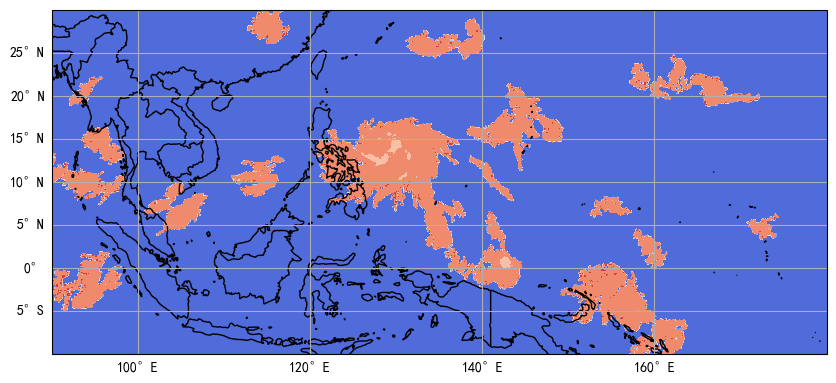

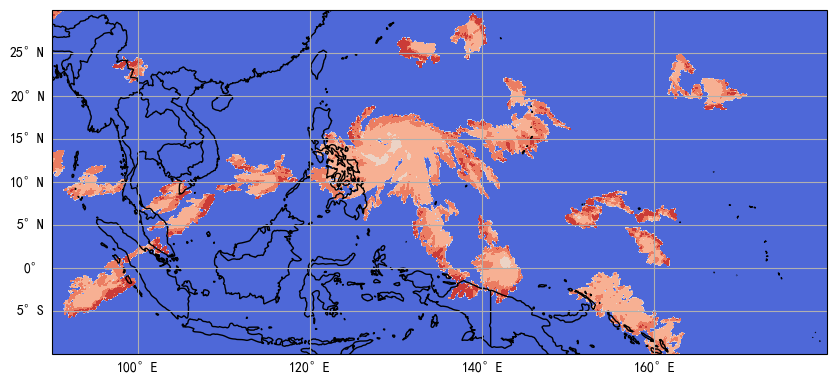

In [99]:
origin_img1  = draw_img(initData_t2.lon, initData_t2.lat, may_mcs_tb_data )
origin_img2  = draw_img(initData_t2.lon, initData_t2.lat, may_mcs_tb_data2 )


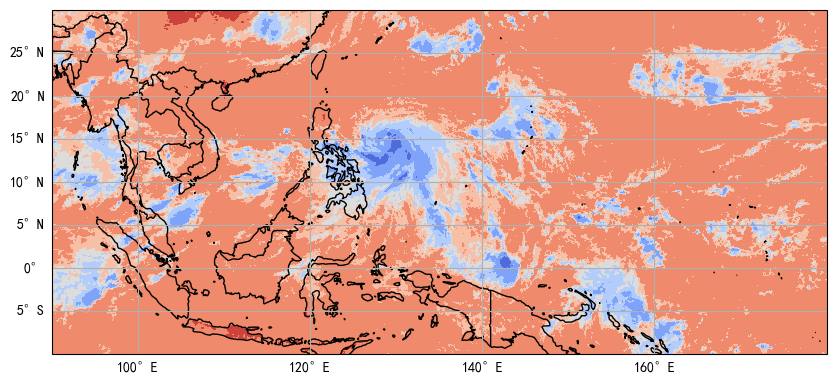

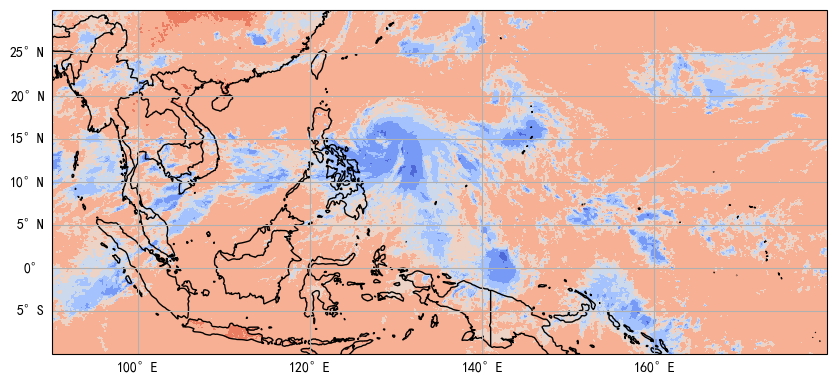

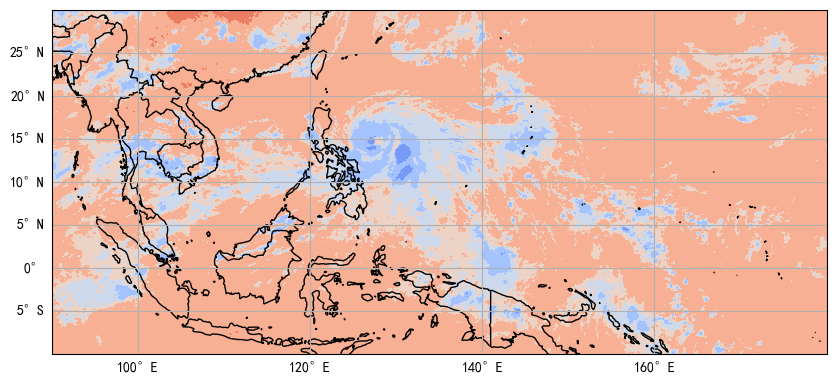

In [12]:
origin_img  = draw_img(initData.lon, initData.lat, initData.irwin_cdr[0] )
# cold_cores_225 = draw_img(initData.lon, initData.lat, cold_cores )
# cold_cores_241 = draw_img(initData.lon, initData.lat, cold_regions )
# cold_cores_map = draw_img(initData.lon, initData.lat, ccs_map )

origin_img2  = draw_img(initData_t2.lon, initData_t2.lat, initData_t2.irwin_cdr[0] )

origin_img3 =  draw_img(initData_t3.lon, initData_t3.lat, initData_t3.irwin_cdr[0] )


## 实现不同时刻覆盖的识别

In [60]:
def calculate_overlap_area(rect1, rect2):
    """
    计算两个矩形的重叠面积。
    :param rect1: 第一个矩形，格式为 (x, y, width, height)
    :param rect2: 第二个矩形，格式为 (x, y, width, height)
    :return: 重叠面积。如果没有重叠，则返回0。
    """
    # 解包矩形参数
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2
    area1 = w1 * h1
    area2 = w2 * h2

    # 计算x轴方向上的重叠
    left = max(x1, x2)
    right = min(x1 + w1, x2 + w2)
    overlap_x = max(0, right - left)

    # 计算y轴方向上的重叠
    top = max(y1, y2)
    bottom = min(y1 + h1, y2 + h2)
    overlap_y = max(0, bottom - top)
    overlap_area = overlap_x * overlap_y
    ration1 = overlap_area/area1
    ration2 = overlap_area/area2
    return max(ration1, ration2)

# # # 示例调用
# rectA = (100, 150, 200, 100)  # 矩形A的坐标和尺寸
# rectB = (150, 175, 100, 150)  # 矩形B的坐标和尺寸
# 
# overlap_area = calculate_overlap_area(rectA, rectB)
# print("重叠面积:", overlap_area)

In [61]:
# 第一个时刻
current_boxes = []
current_boxes_idAndcoords = {}
next_boxes = []
next_boxes_idAndcoords = {}
for i_stats in may_mcs_label_id: 
    i_stats_coord = stats[i_stats, :][0:-1]  # 提取x, y , w, h 
    current_boxes.append(i_stats_coord)
    current_boxes_idAndcoords[str(i_stats)] = i_stats_coord

# 第二个时刻
for i_stats in may_mcs_label_id2: 
    i_stats_coord = stats[i_stats, :][0:-1]  # 提取x, y , w, h 
    next_boxes.append(i_stats_coord)
    next_boxes_idAndcoords[str(i_stats)]= i_stats_coord



In [40]:
def track_boxes(current_boxes, next_boxes, iou_threshold=0.5):
    """
    跟踪当前时刻的框到下一时刻。
    :param current_boxes: 当前时刻的框列表
    :param next_boxes: 下一时刻的框列表
    :param iou_threshold: 判断重叠的阈值，默认为0.5
    :return: 包含结果的字典：
             - tracked_boxes: 跟踪成功的框及其对应关系
             - disappeared_boxes: 没有找到匹配的框（消失的框）
    """   
    tracked_boxes = []
    disappeared_boxes = []
    for current_box in current_boxes:
        best_match = None
        best_iou = 0
        for next_box in next_boxes:    # 迭代得到占比最大的部分， 也就是最好的      
            iou = calculate_overlap_area(current_box, next_box)
            if iou > best_iou:
                best_match = next_box
                best_iou = iou
        if best_iou >= iou_threshold:
            tracked_boxes.append((current_box, best_match))   # current_box, best_match 一样， 显然就表示同一个了
        else:
            disappeared_boxes.append(current_box)

    return {
        "tracked_boxes": tracked_boxes,
        "disappeared_boxes": disappeared_boxes
    }


In [45]:
identified_boxes = track_boxes(current_boxes, next_boxes, iou_threshold=0.5)
tracked_boxes = identified_boxes["tracked_boxes"]
disappeared_boxes = identified_boxes["disappeared_boxes"]

In [54]:
print(len(tracked_boxes))
print(len(disappeared_boxes))
print(tracked_boxes)


3
80
[(array([988,   4, 229, 162], dtype=int32), array([988,   4, 229, 162], dtype=int32)), (array([1273,    4,  118,   61], dtype=int32), array([1273,    4,  118,   61], dtype=int32)), (array([2235,    4,  565,  400], dtype=int32), array([2235,    4,  565,  400], dtype=int32))]


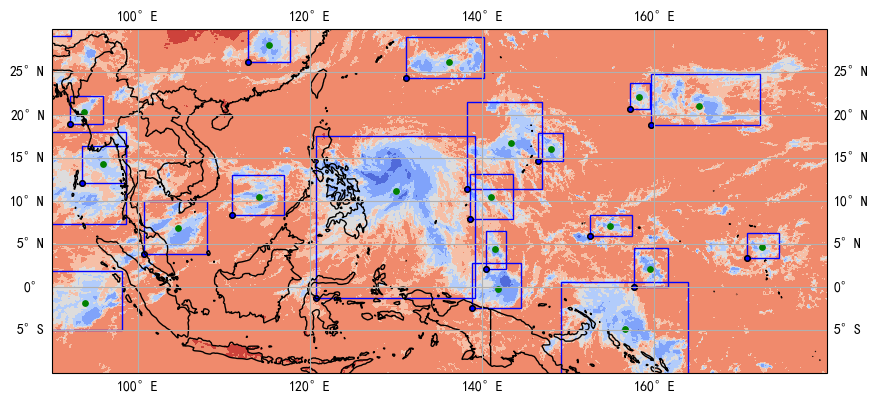

In [136]:
from matplotlib.patches import Polygon

# 创建图形和投影设置
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([90, 180, -10, 30], crs=ccrs.PlateCarree())

# 绘制图像数据
img = ax.contourf(initData.lon, initData.lat, initData.irwin_cdr[0],
                  cmap="coolwarm", transform=ccrs.PlateCarree())

# 设置防止中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# 遍历所有连通组件（跳过背景标签0）
for i in current_boxes_idAndcoords.keys():
    x_min, y_top, width, height, area = stats[int(i)]
    # initData.lon[x_min],   # 左边界 lon_min   
    # initData.lat[y_top ] ,  # 左边界 lat_max
    # initData.lon[x_min + width]  , # 右边界lon_max
    # initData.lat[y_top - height]  # 右边界lat_min
    points = [
    (initData.lon[x_min], initData.lat[y_top ]  ),   # 左上
    (initData.lon[x_min + width] , initData.lat[y_top ] ),   # 右上
    (initData.lon[x_min + width] , initData.lat[y_top + height]),   # 右下
    (initData.lon[x_min], initData.lat[y_top + height])    # 左下
]
    
    polygon = Polygon(points, 
                      closed=True, 
                      edgecolor='blue',
                      facecolor='none', 
                      linewidth=1, 
                      transform=ccrs.PlateCarree())
    ax.add_patch(polygon)
    
    
    ax.scatter(initData.lon[x_min], initData.lat[y_top ],
               s=15, 
               c='b', 
               edgecolors='black', 
               linewidth=1,
               transform=ccrs.PlateCarree(),
               )
    
    ax.scatter(initData.lon[x_min], initData.lat[y_top ],
           s=15, 
           c='b', 
           edgecolors='black', 
           linewidth=1,
           transform=ccrs.PlateCarree(),
           )

    i_centroid_x_index = centroids[int(i)][0]     # 忽略背景
    i_centroid_y_index = centroids[int(i)][1]     # 忽略背景 
    ax.scatter(initData.lon[int(i_centroid_x_index)], 
               initData.lat[int(i_centroid_y_index)],
           s=15, 
           c='g', 
           edgecolors='g', 
           linewidth=1,
           transform=ccrs.PlateCarree(),
           )
 

plt.show()

In [133]:
print(centroids[0][0])
print(centroids[0][1])
print(centroids[0])

int(2549.1916310605748)


2549.1916310605748
1012.3465006990994
[2549.19163106 1012.3465007 ]


2549

In [116]:
print(initData.lon)
print(initData.lat)

<xarray.DataArray 'lon' (lon: 5143)>
array([-180.     , -179.93   , -179.86   , ...,  179.79999,  179.87   ,
        179.94   ], dtype=float32)
Coordinates:
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
Attributes:
    units:          degrees_east
    long_name:      Longitude
    standard_name:  longitude
    actual_range:   [-180.  180.]
<xarray.DataArray 'lat' (lat: 2000)>
array([-70.     , -69.93   , -69.86   , ...,  69.78999,  69.86   ,  69.93001],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -70.0 -69.93 -69.86 -69.79 ... 69.79 69.86 69.93
Attributes:
    units:          degrees_north
    long_name:      Latitude
    standard_name:  latitude
    actual_range:   [-70.  70.]
